# Connecting to Google Drive (Optional)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing libraries

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud

# Importing libraries

In [ ]:
import pandas as pd
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
import numpy as np
from IPython.display import display, HTML
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import VotingClassifier
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from wordcloud import WordCloud

# Importing Dataset

We use an intent classification dataset consisting of online banking queries, each labeled with its corresponding intent. The full dataset contains 77 intent categories with approximately 10,000 training samples and 3,000 testing samples. While the training set is imbalanced across classes, the test set contains a uniform number of samples per class.

For this experiment, we focus on a subset of approximately 1000 training and 240 testing samples belonging to **six** intent classes:

- `card_payment_fee_charged`  
- `wrong_amount_of_cash_received`  
- `transaction_charged_twice`  
- `declined_cash_withdrawal`  
- `transfer_not_received_by_recipient`  
- `request_refund`

These classes are semantically similar and can often overlap in meaning, making this a challenging classification task. This setup provides a strong basis for evaluating the performance and generalization capability of our intent classification model.


In [ ]:

train_df = pd.read_csv('https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/test.csv')

print("no of training samples", len(train_df))
print("no of testing samples", len(test_df))

print("\ncolumns of training data", train_df.columns)
print("columns of testing data", test_df.columns)

print("\nno of categories (clases) in training data\n", len(np.unique(train_df['category'])))
print("no of categories (classes) in testing data\n", len(np.unique(test_df['category'])))

display(HTML("<h3>No of samples by category in training data</h3>"))
display(train_df['category'].value_counts().reset_index())
display(HTML("<h3>No of samples by category in testing data</h3>"))
display(test_df['category'].value_counts().reset_index())

# Display one random sample per category from training and testing sets
display(HTML("<h3>Training sample output (one random per category)</h3>"))
display(train_df.groupby('category').sample(1, random_state=42))

display(HTML("<h3>Testing sample output (one random per category)</h3>"))
display(test_df.groupby('category').sample(1, random_state=42))


selected_categories = [
    "card_payment_fee_charged",
    "wrong_amount_of_cash_received",
    "transaction_charged_twice",
    "declined_cash_withdrawal",
    "transfer_not_received_by_recipient",
    "request_refund"
]

train_df = train_df[train_df['category'].isin(selected_categories)]
test_df = test_df[test_df['category'].isin(selected_categories)]

display(HTML("<h3>After filtering</h3>"))

print("\nno of training samples", len(train_df))
print("no of testing samples", len(test_df))

print("\nno of classes in training data", len(np.unique(train_df['category'])))
print("no of classes in testing data", len(np.unique(test_df['category'])))


no of training samples 10003
no of testing samples 3080

columns of training data Index(['text', 'category'], dtype='object')
columns of testing data Index(['text', 'category'], dtype='object')

no of categories (clases) in training data
 77
no of categories (classes) in testing data
 77


,category,count
0,card_payment_fee_charged,187
1,direct_debit_payment_not_recognised,182
2,balance_not_updated_after_cheque_or_cash_deposit,181
3,wrong_amount_of_cash_received,180
4,cash_withdrawal_charge,177
...,...,...
72,lost_or_stolen_card,82
73,card_swallowed,61
74,card_acceptance,59
75,virtual_card_not_working,41


,category,count
0,card_arrival,40
1,card_linking,40
2,exchange_rate,40
3,card_payment_wrong_exchange_rate,40
4,extra_charge_on_statement,40
...,...,...
72,cash_withdrawal_charge,40
73,card_about_to_expire,40
74,apple_pay_or_google_pay,40
75,verify_my_identity,40


,text,category
5832,"I made a big purchase that I regretted and cancelled, the merchant said that my refund was submi...",Refund_not_showing_up
9193,i cant seem to activate card,activate_my_card
1648,My daughter needs to open account.,age_limit
9699,Are top-ups allowed using Apple Pay?,apple_pay_or_google_pay
4623,I need to know where I can withdraw money.,atm_support
...,...,...
8183,I can't use my virtual disposable card,virtual_card_not_working
4115,"Can you send me a Mastercard, instead of a Visa?",visa_or_mastercard
3861,Why is verifaction required for my Identity?,why_verify_identity
2379,What do I need to do to get cash back? The ATM gave me the wrong amount that I requested but the...,wrong_amount_of_cash_received


,text,category
1779,"i was supposed to get a refund but my balance hasn't changed, why not?",Refund_not_showing_up
2862,I need help with activating my card,activate_my_card
498,Do you offer services for children to have money saving experience?,age_limit
2984,is apple pay costly?,apple_pay_or_google_pay
1454,How can I withdraw money?,atm_support
...,...,...
2538,My disposable virtual card has been rejected by the merchant earlier today. What should I do?,virtual_card_not_working
1288,How to decide if I get a Visa or Mastercard?,visa_or_mastercard
1175,I don't like that I have to fill out so much information about my identity.,why_verify_identity
796,Why did I get less money than I asked for?,wrong_amount_of_cash_received



no of training samples 1055
no of testing samples 240

no of classes in training data 6
no of classes in testing data 6


# Data Preprocessing

For data preprocessing, each text sample is first converted to lowercase, followed by the removal of punctuation, special characters, and extra whitespace. These cleaning steps help standardize the text and are generally required for effective feature extraction using traditional embedding techniques such as TF-IDF.

In [ ]:
def clean_text(text):

   # Convert to lowercase
   text = text.lower()

   # Remove punctuation and special characters
   text = re.sub("r[^a-z0-9\s]", "", text)

   # Remove extra whitespaces
   text = re.sub("\s+", " ", text).strip()

   return text

# Store clean text in new column
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

display(HTML("<h3>Training sample output</h3>"))
display(train_df.drop(columns=['category']).head())
display(HTML("<h3>Testing sample output</h3>"))
display(test_df.drop(columns=['category']).head())


,text,clean_text
2331,Why did I only receive a partial amount of what I tried to withdraw?,why did i only receive a partial amount of what i tried to withdraw?
2332,my atm transaction was wrong,my atm transaction was wrong
2333,why did i only get 20.00,why did i only get 20.00
2334,Why is my cash request and the amount I received different?,why is my cash request and the amount i received different?
2335,"I tried to withdraw $100, all it gave me was $20.","i tried to withdraw $100, all it gave me was $20."


,text,clean_text
760,"I don't know if this is an issue with the ATM or my account, but I just tried withdrawing 30 pou...","i don't know if this is an issue with the atm or my account, but i just tried withdrawing 30 pou..."
761,I didn't get all the cash I requested for at the ATM,i didn't get all the cash i requested for at the atm
762,How come the ATM gave me less cash than what I asked for?,how come the atm gave me less cash than what i asked fo
763,Why did I not get my cash back after I withdrew?,why did i not get my cash back after i withdrew?
764,I got less cash than the one I specified in the ATM,i got less cash than the one i specified in the atm


# Visualization of Dataset: Key Questions

Before moving forward, it is helpful to visualize the dataset in order to better understand its structure. We employ two techniques to investigate the distribution and content of the samples:

## 1. Histogram of Number of Words per Class

We plot a histogram showing, for each class, how many samples contain a given number of words. From this visualization, we observe that the classes **wrong_amount_of_cash_received** and **card_payment_fee_charged** tend to have a higher number of samples that are shorter in length compared to the other classes.


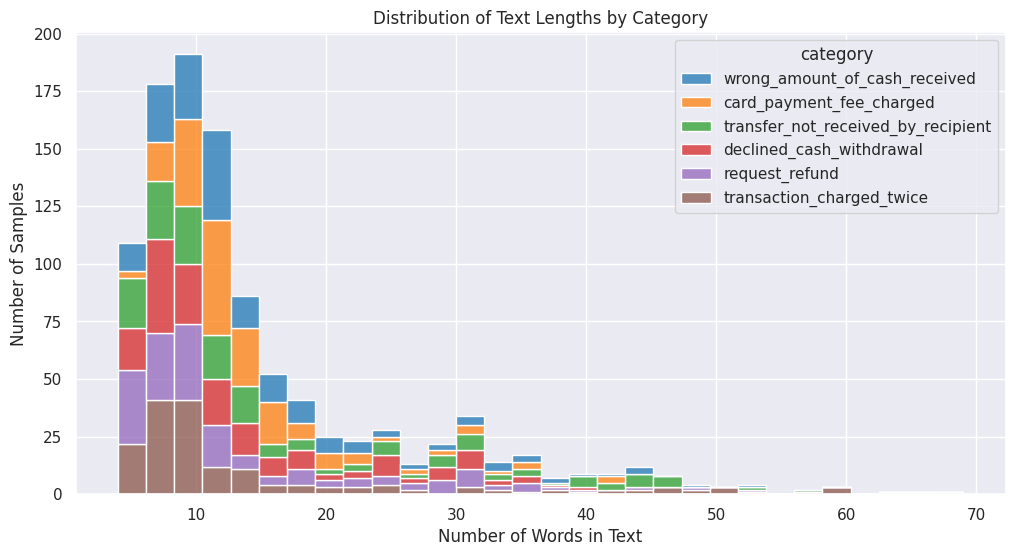

In [ ]:
# Add text length column
train_df['text_length'] = train_df['clean_text'].apply(lambda x: len(x.split()))

# Plot histogram of text lengths per category
plt.figure(figsize=(12,6))
sns.histplot(data=train_df, x='text_length', bins=30, hue='category', multiple='stack', palette='tab10')
plt.title("Distribution of Text Lengths by Category")
plt.xlabel("Number of Words in Text")
plt.ylabel("Number of Samples")
plt.show()


## 2. Word Cloud for Each Category

Next, we generate class-wise word clouds by concatenating all samples from each class into a single document and visualizing the most frequent words. In a word cloud, larger words indicate higher frequency. This allows us to quickly identify dominant terms within each category. We observe that **declined_cash_withdrawal** and **wrong_amount_of_cash_received** share similar frequent terms such as **atm** and **cash**, suggesting that these classes may be harder for the model to distinguish.


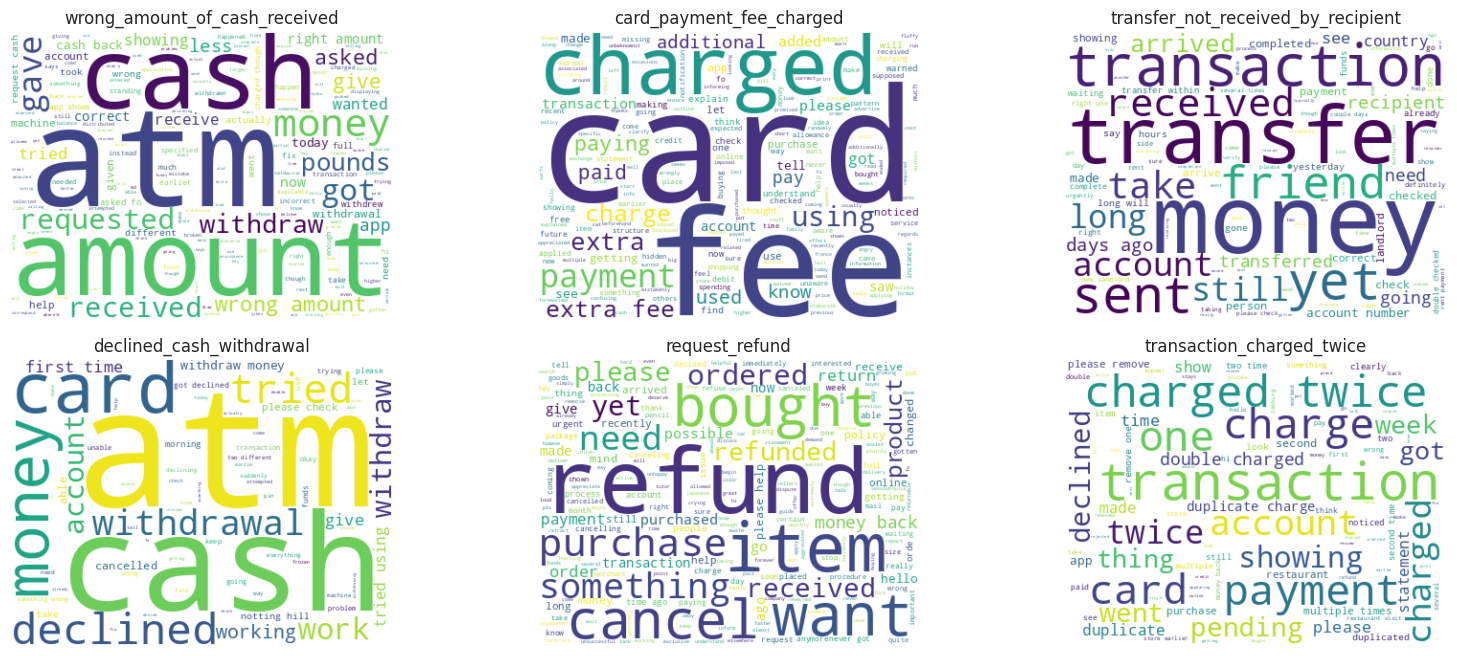

In [ ]:
# Plot word clouds for each category
plt.figure(figsize=(16,10))
for i, cat in enumerate(train_df['category'].unique()):
    plt.subplot(3, 3, i+1)
    text = " ".join(train_df[train_df['category']==cat]['clean_text'])
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(cat)
plt.tight_layout()
plt.show()

# Our Approach: TF-IDF as a Feature Extractor with a Classifier

We use Term Frequency–Inverse Document Frequency (TF-IDF) to transform the raw queries into numerical feature vectors, followed by a classifier to perform intent classification. TF-IDF assigns higher weights to terms that are rare across the dataset and lower weights to common terms, allowing more informative words to stand out. It is lightweight, fast, and widely considered a strong baseline for small to medium-sized text datasets — making it a suitable choice for our scenario. To justify its use, we perform two analyses on the resulting TF-IDF feature space:

## 1. t-SNE Visualization of the TF-IDF Feature Space

We first fit a TF-IDF vectorizer on the training set (with an output feature size of 5000), transform both training and test samples, and then visualize the high-dimensional vectors using t-SNE. The resulting plots show that samples from different classes exhibit clear separation — even in the test set — which suggests that TF-IDF produces discriminative features useful for classification.


TF-IDF output shape (240, 5000)


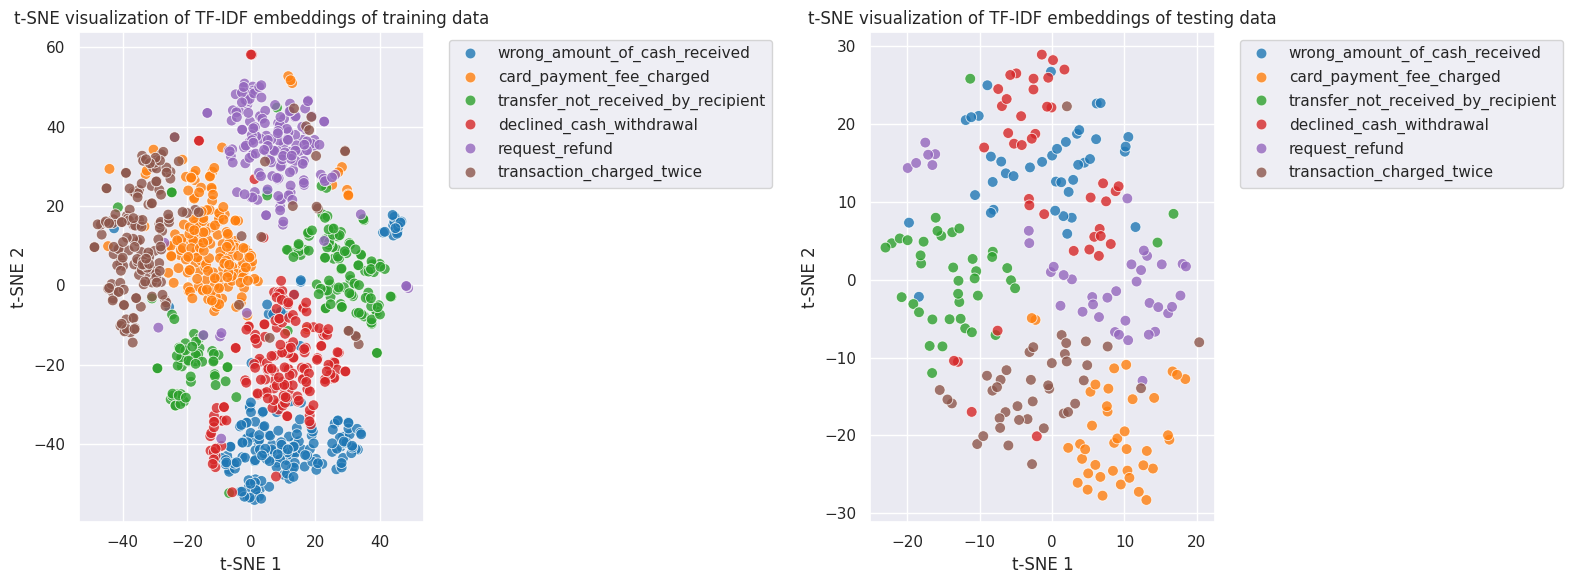

In [ ]:

X_train = train_df['clean_text'].values
y_train = train_df['category'].values

X_test = test_df['clean_text'].values
y_test = test_df['category'].values

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

print("TF-IDF output shape", X_test_tfidf.shape)

# Train two separate TSNE on train and test features produced by TF-IDF
train_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = train_tsne.fit_transform(X_train_tfidf)
test_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_test_tsne = test_tsne.fit_transform(X_test_tfidf)

# Create DataFrame for plotting for both TSNEs
train_tsne_df = pd.DataFrame()
train_tsne_df['TSNE1'] = X_train_tsne[:,0]
train_tsne_df['TSNE2'] = X_train_tsne[:,1]
train_tsne_df['Category'] = y_train

test_tsne_df = pd.DataFrame()
test_tsne_df['TSNE1'] = X_test_tsne[:,0]
test_tsne_df['TSNE2'] = X_test_tsne[:,1]
test_tsne_df['Category'] = y_test

# Plot the TSNE outputs
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=train_tsne_df, x='TSNE1', y='TSNE2', hue='Category', palette='tab10', s=60, alpha=0.8, ax=axes[0])
axes[0].set_title("t-SNE visualization of TF-IDF embeddings of training data")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=test_tsne_df, x='TSNE1', y='TSNE2', hue='Category', palette='tab10', s=60, alpha=0.8, ax=axes[1])
axes[1].set_title("t-SNE visualization of TF-IDF embeddings of testing data")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 2. Intra- vs Inter-Class Cosine Similarity Analysis

Next, we compute cosine similarity scores between TF-IDF vectors to quantify how well samples cluster in feature space. If samples belonging to the same class (intra-class) have higher similarity to each other than to samples of other classes (inter-class), it indicates that TF-IDF is extracting meaningful representations.

- **Training set:**  
  Intra-class similarity = 0.0668 (≈3.5× higher than inter-class similarity 0.0189) → Gap = 0.0479  
- **Test set:**  
  Intra-class similarity = 0.0803 (≈3.7× higher than inter-class similarity 0.0216) → Gap = 0.0587

Finally, box plots of the similarity scores further confirm the effectiveness of the feature space: intra-class similarity consistently shows higher medians and more extreme values than inter-class similarity on both splits.

Since intra-class similarity is consistently higher than inter-class similarity in both training and test sets, TF-IDF provides a meaningful separation of intents in feature space, enabling downstream classifiers to learn accurate decision boundaries.

Average Intra-class Cosine Similarity:  0.0668
Average Inter-class Cosine Similarity: 0.0189
Difference (Intra - Inter): 0.0479



Average Intra-class Cosine Similarity:  0.0803
Average Inter-class Cosine Similarity: 0.0216
Difference (Intra - Inter): 0.0587



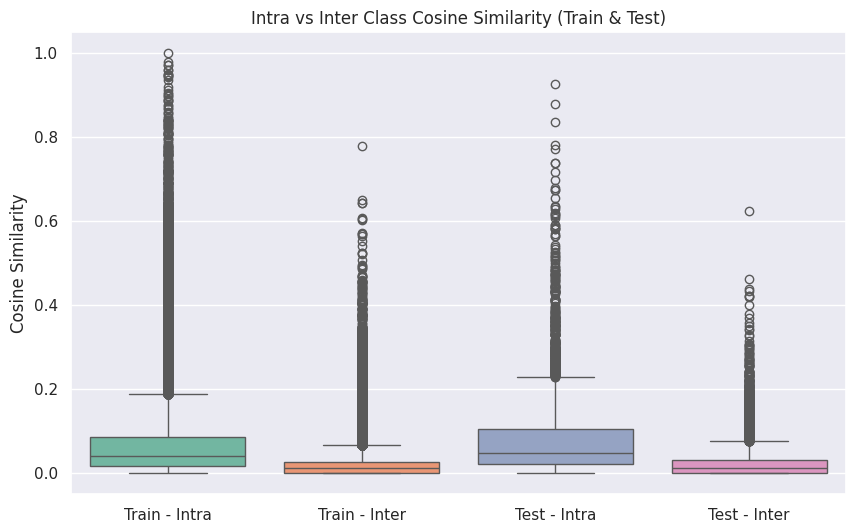

In [ ]:

# function for finding intra-inter similarity (will be used for both train and test data)
def intra_inter_similarity(X_tfidf, y_labels, set_name):

    # Find cosine similarity
    cos_sim_matrix = cosine_similarity(X_tfidf)

    intra_sims = []
    inter_sims = []

    for i in range(len(y_labels)):
        for j in range(i+1, len(y_labels)):
            if y_labels[i] == y_labels[j]:
                intra_sims.append(cos_sim_matrix[i, j])
            else:
                inter_sims.append(cos_sim_matrix[i, j])

    avg_intra = np.mean(intra_sims)
    avg_inter = np.mean(inter_sims)

    display(HTML(f"<h3>{set_name} data metrics</h3>"))
    print(f"Average Intra-class Cosine Similarity:  {avg_intra:.4f}")
    print(f"Average Inter-class Cosine Similarity: {avg_inter:.4f}")
    print(f"Difference (Intra - Inter): {avg_intra - avg_inter:.4f}\n")

    # Return data
    return intra_sims, inter_sims


X_train = train_df['clean_text'].values
y_train = train_df['category'].values

X_test = test_df['clean_text'].values
y_test = test_df['category'].values

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# Train set similarities
train_intra, train_inter = intra_inter_similarity(X_train_tfidf, y_train, "Train")

# Test set similarities
test_intra, test_inter = intra_inter_similarity(X_test_tfidf, y_test, "Test")

# Plot boxplots
plt.figure(figsize=(10,6))
sns.boxplot(
    data=[train_intra, train_inter, test_intra, test_inter],
    palette="Set2"
)
plt.xticks([0,1,2,3], ['Train - Intra', 'Train - Inter', 'Test - Intra', 'Test - Inter'])
plt.ylabel("Cosine Similarity")
plt.title("Intra vs Inter Class Cosine Similarity (Train & Test)")
plt.show()


# Selecting Classifiers

To evaluate our feature space, we experiment with three traditional linear classifiers: **Logistic Regression**, **Naive Bayes**, and **Support Vector Machine (SVM)**. Each classifier has its own strengths: Logistic Regression is robust and interpretable, Naive Bayes is fast and works well on high-dimensional sparse data, while SVMs are powerful at finding decision boundaries in complex feature spaces.

Our goal is to train, validate, and perform hyperparameter tuning on these models to identify the best-performing classifier and hyperparameter configuration for our task. We follow two different validation strategies, detailed below.


In [ ]:
# Classifiers and their corresponding hyperparameters
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'NaiveBayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.5, 1.0, 1.5]
        }
    },
    'LinearSVM': {
        'model': LinearSVC(random_state=42, max_iter=10000),
        'params': {
            'C': [0.1, 1, 10]
        }
    }
}

# dictionary to store the performance of classifiers
results = {
    'classifier': [],
    'best_params': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1_score': [],
    'validation_type': []
}


## 1. Hyperparameter Tuning Using a Train/Validation Split

In this approach, we reserve **20% of the training set** as a validation set for hyperparameter tuning.

### Dividing Data into Train, Validation, and Test Sets

We split the original training data into a training and validation set and keep the test set untouched for final evaluation.


In [ ]:
# keep backup copies for later use
train_data = train_df.copy()
test_data = test_df.copy()

# keep test_df as is, create validation data from training data
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['category'], random_state=42)

display(HTML("<h3>No of samples by category in training data</h3>"))
display(train_df['category'].value_counts().reset_index())
display(HTML("<h3>No of samples by category in validation data</h3>"))
display(val_df['category'].value_counts().reset_index())

,category,count
0,card_payment_fee_charged,150
1,wrong_amount_of_cash_received,144
2,transaction_charged_twice,140
3,declined_cash_withdrawal,138
4,transfer_not_received_by_recipient,137
5,request_refund,135


,category,count
0,card_payment_fee_charged,37
1,wrong_amount_of_cash_received,36
2,declined_cash_withdrawal,35
3,transaction_charged_twice,35
4,transfer_not_received_by_recipient,34
5,request_refund,34


### Hyperparameter Tuning on the Validation Set

Each classifier undergoes hyperparameter tuning on the validation set. For each model, we record the **average accuracy**, **weighted precision**, **weighted recall**, and **weighted F1-score** corresponding to its best-performing hyperparameter configuration. In this setup, **Logistic Regression** and **Linear SVM** both reach up to **99% validation accuracy**.


In [ ]:
X_train = train_df['clean_text'].values
y_train = train_df['category'].values
X_val = val_df['clean_text'].values
y_val = val_df['category'].values

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

for name, clf_info in classifiers.items():

    # get parameters names and values for the current classifier
    param_names = list(clf_info['params'].keys())
    param_values = list(clf_info['params'].values())
    all_combinations = [dict(zip(param_names, v)) for v in product(*param_values)]

    best_accuracy = 0
    best_params = None
    best_y_pred = None

    for param in all_combinations:
      clf = clf_info['model'].__class__(**param)

      # train and do model prediction
      clf.fit(X_train_tfidf, y_train)
      y_pred = clf.predict(X_val_tfidf)
      accuracy = accuracy_score(y_val, y_pred)

      if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = param
        best_y_pred = y_pred

    results['classifier'].append(name)
    results['val_accuracy'].append(best_accuracy)
    results['val_precision'].append(precision_score(y_val, best_y_pred, average='weighted', zero_division=0))
    results['val_recall'].append(recall_score(y_val, best_y_pred, average='weighted', zero_division=0))
    results['val_f1_score'].append(f1_score(y_val, best_y_pred, average='weighted', zero_division=0))
    results['validation_type'].append('training, validation data split')
    results['best_params'].append(best_params)

display(pd.DataFrame(results))

,classifier,best_params,val_accuracy,val_precision,val_recall,val_f1_score,validation_type
0,LogisticRegression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.990521,0.990781,0.990521,0.990519,"training, validation data split"
1,NaiveBayes,{'alpha': 0.5},0.971564,0.971930,0.971564,0.971618,"training, validation data split"
2,LinearSVM,{'C': 1},0.990521,0.990781,0.990521,0.990519,"training, validation data split"


## 2. Hyperparameter Tuning with K-Fold Cross-Validation

To obtain more robust and less over-optimistic estimates, we concatenate the original training and testing sets and apply **K-fold cross-validation** with **K = 3**. The results from this evaluation are appended to the previous dataframe containing results from the train/validation split.

Cross-validation generally provides a better estimate of generalization performance, since each sample is used for training and evaluation in at least one fold. Based on this approach, we select the following hyperparameters for our final evaluation:

- **Logistic Regression:** `{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}`  
- **Naive Bayes:** `{'alpha': 0.5}`  
- **Linear SVM:** `{'C': 10}`

These hyperparameters are used in the next stage for final testing on the held-out dataset.


In [ ]:

train_df = train_data.copy()
X = train_df['clean_text'].values
y = train_df['category'].values

# Custom scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1_score': make_scorer(f1_score, average='weighted', zero_division=0),
}

for name, clf_info in classifiers.items():

    # Concatenate 'clf__' in start of each key to make sure GridSearchCV works properly
    clf_info['params'] = { 'clf__' + k:v for k,v in clf_info['params'].items()}

    # Create a pipeline: TF-IDF + classifier
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', clf_info['model'])
    ])

    # Grid search with 3-fold CV
    grid = GridSearchCV(
        pipeline,
        param_grid=clf_info['params'],
        cv=3,
        scoring=scoring,
        refit='accuracy',  # refit on accuracy metric
        n_jobs=-1
    )

    grid.fit(X, y)

    # Store results
    results['classifier'].append(name)
    clean_best_params = {k.split('__')[1]:v for k, v in grid.best_params_.items()}
    results['best_params'].append(clean_best_params)
    results['val_accuracy'].append(grid.cv_results_['mean_test_accuracy'][grid.best_index_])
    results['val_precision'].append(grid.cv_results_['mean_test_precision'][grid.best_index_])
    results['val_recall'].append(grid.cv_results_['mean_test_recall'][grid.best_index_])
    results['val_f1_score'].append(grid.cv_results_['mean_test_f1_score'][grid.best_index_])
    results['validation_type'].append('3 fold')

    # Change the params back to its original shape
    clf_info['params'] = { k.split('__')[1]:v for k,v in clf_info['params'].items()}

display(pd.DataFrame(results))


,classifier,best_params,val_accuracy,val_precision,val_recall,val_f1_score,validation_type
0,LogisticRegression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.990521,0.990781,0.990521,0.990519,"training, validation data split"
1,NaiveBayes,{'alpha': 0.5},0.971564,0.971930,0.971564,0.971618,"training, validation data split"
2,LinearSVM,{'C': 1},0.990521,0.990781,0.990521,0.990519,"training, validation data split"
3,LogisticRegression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.969665,0.970379,0.969665,0.969622,3 fold
4,NaiveBayes,{'alpha': 0.5},0.963033,0.963632,0.963033,0.962923,3 fold
5,LinearSVM,{'C': 10},0.973455,0.974382,0.973455,0.973413,3 fold


## Testing Performance with Best Hyperparameter Combinations and Saving Models

Next, we retrain all three classifiers using their selected best-performing hyperparameters on the full **training set**, and then evaluate them on the **held-out test set**. After training, we serialize both the trained classifiers and the fitted TF-IDF vectorizer for later use during inference.


In [ ]:
# Path to store the vectorizer and models (change it if needed)
SAVE_PATH = "/content/drive/MyDrive/Assessment_project"
os.makedirs(SAVE_PATH, exist_ok=True)

train_df = train_data.copy()

X_train = train_df['clean_text'].values
y_train = train_df['category'].values

# Convert text to embeddings
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)

# Initializing the models with best hyperparameters found
clf1 = LinearSVC(max_iter=1000, random_state=42, C=10)
clf2 = MultinomialNB(alpha=0.5)
clf3 = LogisticRegression(max_iter=1000, random_state=42, C=10, penalty='l2',solver='lbfgs')

# Train and do models prediction
clf1.fit(X_train_tfidf, y_train)
clf2.fit(X_train_tfidf, y_train)
clf3.fit(X_train_tfidf, y_train)


# Store vectorizer and models
with open(f"{SAVE_PATH}/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open(f"{SAVE_PATH}/linear_svc_model.pkl", "wb") as f:
    pickle.dump(clf1, f)

with open(f"{SAVE_PATH}/naive_bayes_model.pkl", "wb") as f:
    pickle.dump(clf2, f)

with open(f"{SAVE_PATH}/logistic_regression_model.pkl", "wb") as f:
    pickle.dump(clf3, f)

print("Vectorizer and models stored!")

Vectorizer and models stored!


## Model Evaluation

We load the saved vectorizer and models, and evaluate their performance on the test data by computing precision, recall, and F1-score by class and average (both macro and weighted), along with confusion matrices.

**Logistic Regression** achieves the highest test accuracy of **97.5%**, slightly outperforming **Naive Bayes** and **Linear SVM**, which both achieve **96.6%**. Based on this, we select **Logistic Regression** as the final inference model for deployment in our FastAPI application.

A closer look at the confusion matrices reveals that all classifiers occasionally confuse the classes **`wrong_amount_of_cash_received`** and **`declined_cash_withdrawal`** — which is consistent with our earlier observations during the word cloud analysis, where these two classes shared similar high-frequency terms.


,precision,recall,f1-score,support
card_payment_fee_charged,1.000000,0.975000,0.987342,40.0
declined_cash_withdrawal,0.926829,0.950000,0.938272,40.0
request_refund,1.000000,0.975000,0.987342,40.0
transaction_charged_twice,0.975610,1.000000,0.987654,40.0
transfer_not_received_by_recipient,0.975610,1.000000,0.987654,40.0
wrong_amount_of_cash_received,0.923077,0.900000,0.911392,40.0
macro avg,0.966854,0.966667,0.966609,240.0
weighted avg,0.966854,0.966667,0.966609,240.0


,precision,recall,f1-score,support
card_payment_fee_charged,0.97500,0.975000,0.975000,40.0
declined_cash_withdrawal,0.95000,0.950000,0.950000,40.0
request_refund,1.00000,0.950000,0.974359,40.0
transaction_charged_twice,0.97561,1.000000,0.987654,40.0
transfer_not_received_by_recipient,0.97561,1.000000,0.987654,40.0
wrong_amount_of_cash_received,0.92500,0.925000,0.925000,40.0
macro avg,0.96687,0.966667,0.966611,240.0
weighted avg,0.96687,0.966667,0.966611,240.0


,precision,recall,f1-score,support
card_payment_fee_charged,1.000000,0.975,0.987342,40.0
declined_cash_withdrawal,0.951220,0.975,0.962963,40.0
request_refund,0.975000,0.975,0.975000,40.0
transaction_charged_twice,1.000000,1.000,1.000000,40.0
transfer_not_received_by_recipient,0.975610,1.000,0.987654,40.0
wrong_amount_of_cash_received,0.948718,0.925,0.936709,40.0
macro avg,0.975091,0.975,0.974945,240.0
weighted avg,0.975091,0.975,0.974945,240.0


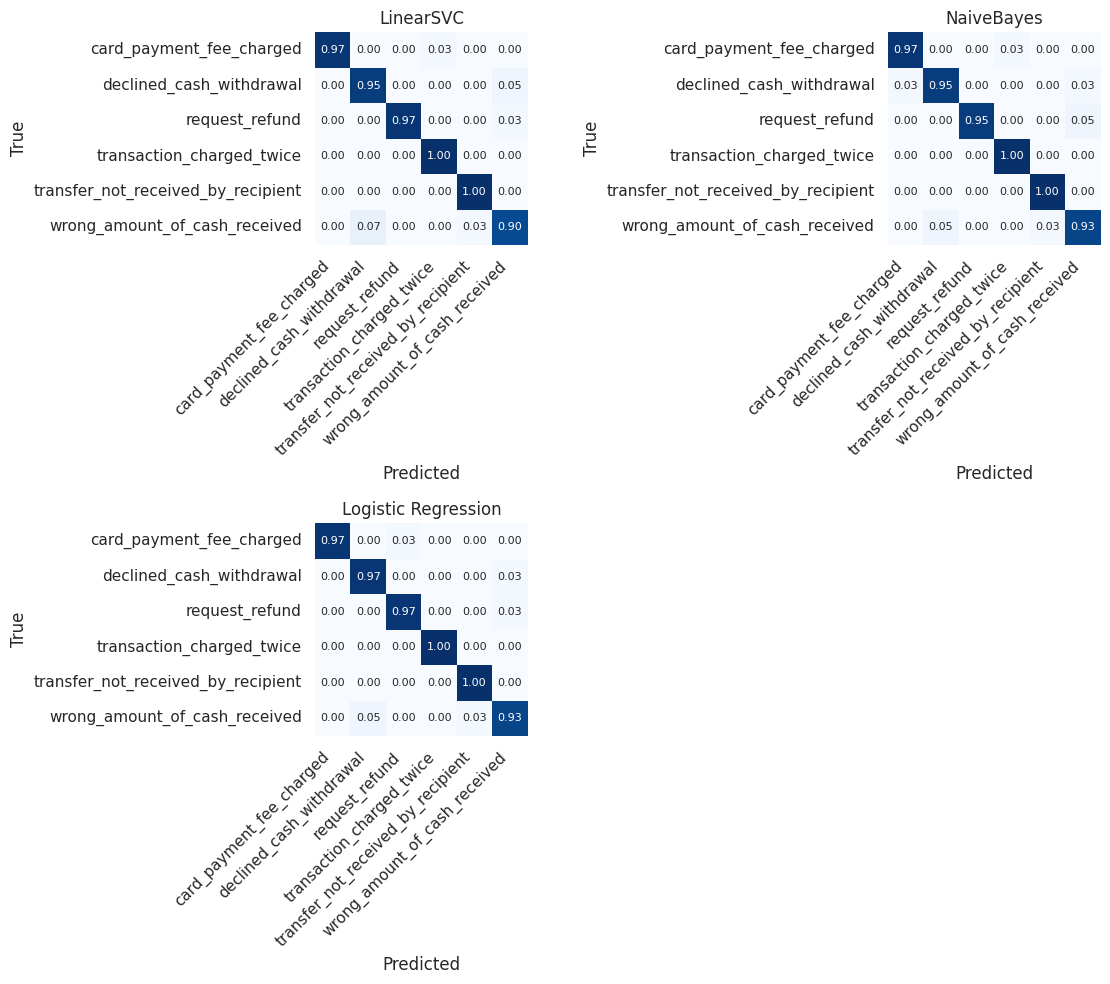

In [ ]:
test_df = test_data.copy()

X_test = test_df['clean_text'].values
y_test = test_df['category'].values

# Read vectorizer and models
with open(f"{SAVE_PATH}/tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open(f"{SAVE_PATH}/linear_svc_model.pkl", "rb") as f:
    clf1 = pickle.load(f)

with open(f"{SAVE_PATH}/naive_bayes_model.pkl", "rb") as f:
    clf2 = pickle.load(f)

with open(f"{SAVE_PATH}/logistic_regression_model.pkl", "rb") as f:
    clf3 = pickle.load(f)

X_test_tfidf = tfidf.transform(X_test)

# Do model predictions
y_pred1 = clf1.predict(X_test_tfidf)
y_pred2 = clf2.predict(X_test_tfidf)
y_pred3 = clf3.predict(X_test_tfidf)

# Display classification report for each classifier

report = classification_report(y_test, y_pred1, digits=2, output_dict=True)
display(HTML(f"<h3>Linear Support Vector Machine Accuracy: {report.pop('accuracy')}</h3>"))
display(pd.DataFrame(report).transpose())

report = classification_report(y_test, y_pred2, digits=2, output_dict=True)
display(HTML(f"<h3>NaiveBayes Accuracy: {report.pop('accuracy')}</h3>"))
display(pd.DataFrame(report).transpose())

report = classification_report(y_test, y_pred3, digits=2, output_dict=True)
display(HTML(f"<h3>Logistic Regression Accuracy: {report.pop('accuracy')}</h3>"))
display(pd.DataFrame(report).transpose())

# Display confusion matrix for all classifiers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

predictions = [
    (y_pred1, clf1.classes_, 'LinearSVC'),
    (y_pred2, clf2.classes_, 'NaiveBayes'),
    (y_pred3, clf3.classes_, 'Logistic Regression')
]

for i, (y_pred, classes, title) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(
        cm_normalized,
        annot=True, fmt=".2f", cmap="Blues",
        xticklabels=classes, yticklabels=classes,
        cbar=False, ax=axes[i], square=True,
        annot_kws={"size":8}
    )

    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right")

# Remove unused subplot
fig.delaxes(axes[3])

plt.tight_layout()
plt.show()



## Confidence and Error Analysis

To better understand classifier behavior, we perform both **confidence analysis** and **error analysis**:

- **Confidence Analysis:**   
  For each classifier, we record the maximum predicted probability (or decision function score) for each test sample. Plotting these confidence distributions reveals that:
  - **Linear SVM** is the most confident (highest density around 0.9),
  - followed by **Logistic Regression**,
  - and then **Naive Bayes**.

- **Error Analysis:**   
  We extract test samples where the prediction is incorrect yet the classifier is **highly confident** (confidence > 0.7). Across all models, the most common high-confidence misclassification is **`wrong_amount_of_cash_received`** being predicted as **`declined_cash_withdrawal`**, followed by **`transfer_not_received_by_recipient`**.  

This indicates that, although overall performance is high, all classifiers systematically struggle with the same closely-related intent classes — highlighting a potential area for future improvement.



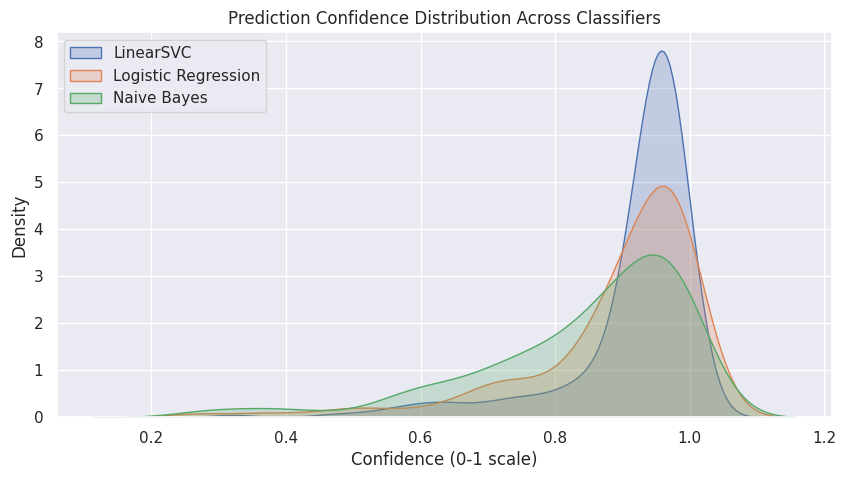

,classifier,confidence,text,true class,predicted class
0,LinearSVM,0.836330,where is the money i pushed it's on my mobile app as being withdrawn.,wrong_amount_of_cash_received,transfer_not_received_by_recipient
1,LinearSVM,0.950014,will declined funds i tried to withdraw be returned to me?,wrong_amount_of_cash_received,declined_cash_withdrawal
2,NaiveBayes,0.884087,my cash withdrawal was partly declined,wrong_amount_of_cash_received,declined_cash_withdrawal
3,NaiveBayes,0.714982,will declined funds i tried to withdraw be returned to me?,wrong_amount_of_cash_received,declined_cash_withdrawal
4,LogisticRegression,0.724945,where is the money i pushed it's on my mobile app as being withdrawn.,wrong_amount_of_cash_received,transfer_not_received_by_recipient
5,LogisticRegression,0.788032,my cash withdrawal was partly declined,wrong_amount_of_cash_received,declined_cash_withdrawal
6,LogisticRegression,0.889425,will declined funds i tried to withdraw be returned to me?,wrong_amount_of_cash_received,declined_cash_withdrawal


In [ ]:

test_df = test_data.copy()

X_test = test_df['clean_text'].values
y_test = test_df['category'].values

# Read vectorizer and models
with open(f"{SAVE_PATH}/tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

with open(f"{SAVE_PATH}/linear_svc_model.pkl", "rb") as f:
    clf1 = pickle.load(f)

with open(f"{SAVE_PATH}/naive_bayes_model.pkl", "rb") as f:
    clf2 = pickle.load(f)

with open(f"{SAVE_PATH}/logistic_regression_model.pkl", "rb") as f:
    clf3 = pickle.load(f)

X_test_tfidf = tfidf.transform(X_test)

# Take maximum confidence from predictions of all the classifiers
clf1_cal = CalibratedClassifierCV(clf1, cv=5)
clf1_cal.fit(tfidf.transform(X_train), y_train)
confidence_svc = clf1_cal.predict_proba(X_test_tfidf).max(axis=1)

confidence_nb = clf2.predict_proba(X_test_tfidf).max(axis=1)
confidence_lr = clf3.predict_proba(X_test_tfidf).max(axis=1)

plt.figure(figsize=(10,5))
sns.kdeplot(confidence_svc, label='LinearSVC', fill=True)
sns.kdeplot(confidence_lr, label='Logistic Regression', fill=True)
sns.kdeplot(confidence_nb, label='Naive Bayes', fill=True)

plt.title("Prediction Confidence Distribution Across Classifiers")
plt.xlabel("Confidence (0-1 scale)")
plt.ylabel("Density")
plt.legend()
plt.show()

high_conf_threshold = 0.7

wrong_pred = {
    'classifier': [],
    'confidence': [],
    'text': [],
    'true class': [],
    'predicted class':[]
}

predictions = [(y_pred1, confidence_svc, 'LinearSVM'),(y_pred2, confidence_nb, 'NaiveBayes'),
 (y_pred3, confidence_lr, 'LogisticRegression')]

for y_pred, confidence, name in predictions:
    # Store the high confidence predictions in dataframe
    mask = (y_test != y_pred) & (confidence > high_conf_threshold)
    for i in np.where(mask)[0]:
        wrong_pred['confidence'].append(confidence[i])
        wrong_pred['classifier'].append(name)
        wrong_pred['true class'].append(y_test[i])
        wrong_pred['predicted class'].append(y_pred[i])
        wrong_pred['text'].append(X_test[i])


# Display class wrongly classified by high confidence predictions
display(HTML("<h3>High-confidence misclassified samples for three classifiers</h3>"))
display(pd.DataFrame(wrong_pred))



## Ensemble Model Experiment

To further boost performance, we performed an ensemble experiment by combining the three trained classifiers through **majority voting** on the test set. Unfortunately, this ensemble achieved **97% accuracy**, which is slightly *lower* than our standalone Logistic Regression model. Therefore, we conclude that ensembling does not provide additional benefit in this particular setup.


In [ ]:
# Define the pipeline with TF-IDF and classifiers

train_df = train_data.copy()
test_df = test_data.copy()

X_train = train_df['clean_text'].values
y_train = train_df['category'].values

X_test = test_df['clean_text'].values
y_test = test_df['category'].values

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

clf1 = LinearSVC(max_iter=1000, random_state=42, C=10)
clf2 = MultinomialNB(alpha=0.5)
clf3 = LogisticRegression(max_iter=1000, random_state=42, C=10, penalty='l2',solver='lbfgs')

# Voting classifier (hard voting)
ensemble = VotingClassifier(
    estimators=[('svm', clf1), ('nb', clf2), ('lr', clf3)],
    voting='hard'
)

# Creating pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('ensemble', ensemble)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

display(HTML("<h3> Ensemble model accuracy </h3>"))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("precision-score:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("recall-score:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("f1-score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))

Accuracy: 0.9708333333333333
precision-score: 0.9713414634146341
recall-score: 0.9708333333333333
f1-score: 0.9709322570433682



# Conclusion

We designed and evaluated a lightweight yet effective **feature extractor + classifier pipeline** for intent classification. Specifically, we used **TF-IDF** to convert text queries into numerical feature vectors and, after extensive experimentation with multiple classifiers, selected **Logistic Regression** as the final model.

The proposed approach delivers strong performance (97.5% accuracy) while remaining **fast**, **interpretable**, and **computationally efficient**. Misclassifications were largely confined to semantically similar intent classes, suggesting potential limitations in the TF-IDF feature space rather than the classifiers themselves.

Future improvements could involve using more powerful, context-aware embeddings such as **fastText** or **transformer-based models (e.g., BERT)**, which can better capture semantic nuances between similar phrases, but at a higher computational cost. Overall, our TF-IDF + Logistic Regression setup strikes an excellent balance between **speed**, **accuracy**, and **deployability**, making it well-suited for real-time inference in practical systems.